In [2]:
import pandas as pd
import os
import glob
import matplotlib as mpl
from datetime import datetime
from cycler import cycler
import math
import numpy as np
from PyPDF2 import PdfFileMerger
#mpl.use('pgf')
import matplotlib.pyplot as plt

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['lines.markersize'] = 1.0
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.rcParams['pgf.preamble'] = [r'\usepackage{hyperref} \hypersetup{hidelinks,''colorlinks=true, urlcolor=cyan}', ]
#plt.rcParams['pgf.preamble'] = [r'\usepackage{hyperref}',]

from platform import python_version

print(python_version())

3.9.7


In [28]:
if False:
    plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": '\n'.join([
         r'\usepackage{url}',            # load additional packages
         r'\usepackage{unicode-math}',   # unicode math setup
         #r'\setmainfont{DejaVu Serif}'',  # serif font via preamble
         r'\usepackage{hyperref}',
        r'\usepackage{pgfplots}',
        r'\usepgfplotslibrary{external}',
        r'\tikzexternalize{main}',
        r'\tikzsetexternalprefix{external_figs/}',
    ])
    })


In [3]:
dir_front = "../FE_block1_autotracks_front"
dir_back = "../FE_block1_autotracks_back"
def filter_camera_names(list_of_names):
    return [name for name in list_of_names if len(name)==8 and name.isnumeric()]
cameras = filter_camera_names(os.listdir(dir_front))
days = [name[:8] for name in os.listdir(dir_front+"/"+cameras[0]) if name[:8].isnumeric()]
days.sort()
test_b = dir_back+cameras[0]+"/20210911_060000.23442333/23442333_20210911_060000.23442333_000004_2021-11-13T13_15_22_13428.csv"

c_idx = 0
filenames_f = glob.glob("{}/{}/{}*/*.csv".format(dir_front, cameras[c_idx], days[0]), recursive=True)
filenames_b = glob.glob("{}/{}/{}*/*.csv".format(dir_back,cameras[c_idx], days[0]), recursive=True)

In [4]:
def read_batch_csv(filename):
    df = pd.read_csv(filename,skiprows=3, delimiter=';', error_bad_lines=False, usecols=["x", "y", "time"])
    df.dropna(axis=0, how="any", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def merge_files(filenames):
    batches = []
    filenames.sort()
    for f in filenames:
        df = read_batch_csv(f)
        batches.append(df)
        #print(get_time_for_day(df.time[0]), get_time_for_day(df.time[len(df.time)-1]))
    return batches

"""
@params: camera, day
returns (front, back) csv of the day 
"""
def csv_of_the_day(camera, day):
    data_f = []
    data_b = []
    filenames_f = glob.glob("{}/{}/{}*/*.csv".format(dir_front, camera, day), recursive=True)
    filenames_b = glob.glob("{}/{}/{}*/*.csv".format(dir_back, camera, day), recursive=True)
    return (merge_files(filenames_f), merge_files(filenames_b))
            
            
day1 = csv_of_the_day(cameras[0], days[0])

In [42]:
from matplotlib.backends.backend_pdf import PdfPages

def get_position_string(is_back):
    if is_back:
        return "back"
    else:
        return "front"

"""
@params days: [(folder, start_time)]
"""
def pdf_for_fish(camera_id,days : [(str, str)],is_back=False):
    position_str = get_position_string(is_back)
    
    with PdfPages('trajectory_{}_{}_{}_{}.pdf'.format(
        camera_id,position_str,
        get_date_from_time(days[0][1]), 
        get_date_from_time(days[-1][1])
    )) as pdf:
        for day in days:
            day_df = csv_of_the_day(camera_id, day[0])
            fig = plot_day_camera(day_df, camera_id, is_back)
            pdf.savefig(fig,  bbox_inches='tight')
            
def pdf_for_fish_tex(camera_id,days : [(str, str)],is_back=False):
    position_str = get_position_string(is_back)
    
    merger = PdfFileMerger()
    for day in days:
        day_df = csv_of_the_day(camera_id, day[0])
        fig = plot_day_camera(day_df, camera_id, is_back)
        #fig.text(0.5, 0.5, r'\href{https://stackoverflow.com/questions/}{StackOverflow '+day[0]+'}')
        out = './out{}.pdf'.format(day[0])
        fig.savefig(out, bbox_inches='tight')
        merger.append(out)
        os.remove(out)

    merger.write('./trajectory_{}_{}_{}_{}.pdf'.format(
            camera_id,
            position_str,
            get_date_from_time(days[0][1]), 
            get_date_from_time(days[-1][1])
        ))
    merger.close()

In [6]:
m_days = map(lambda d: read_batch_csv(glob.glob("{}/{}/{}*/*.csv".format(dir_front, cameras[0], d), recursive=True)[0]).time[0],days)
days_map = list(zip(days, m_days))
days_map.sort(key=lambda x: x[1])


In [44]:
def get_time_for_day(t_stamp):
    return datetime.fromtimestamp(t_stamp/1000.0).strftime("%H:%M:%S")

def get_date_from_time(t_stamp):
    return datetime.fromtimestamp(t_stamp/1000.0).strftime("%Y%m%d")

def plot_day_camera(day, camera_id, is_back=False, write_single_plots=False):
    xlim=[-5, 90]
    ylim=[-40, 2]
    data = day[is_back]
    nrows=4
    ncols=4
        
    position = get_position_string(is_back)
    if is_back:
        ylim=[-2, 40] 
    
    fig, axis = plt.subplots(figsize=(4*ncols,2*nrows), dpi=50, nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    title="{}\nTrajectory over time of the molly at\n camera: {}\n position: {}".format(
        datetime.fromtimestamp(data[0].time[0]/1000.0).strftime("%A, %B %d, %Y %H:%M"),
        camera_id,
        position
    )
    fig.suptitle(title,x=0.22, y=0.85)
    for j in range(ncols):
        axis[-1][j].set(
            xlabel='x coordinate',
            xlim=xlim
        )
        
    for i in range(nrows):
        axis[i][0].set(
            ylabel='y coordinate',
            ylim=ylim
        )
        for j in range(ncols):
            if (i == j and j == 0):
                axis[i][j].axis('off')
                continue
            idx = i * ncols + j - 1
            if idx >= len(data):
                break
            low, up = 0, len(data[idx].x)-1
            label='All trajectory points front '
            batch_size= 100
            time_span="{} - {}".format(get_time_for_day(data[idx].time[low]),get_time_for_day(data[idx].time[up]))
            axis[i][j].set_title(time_span,fontsize=10)
                
        
            for k in range(low,up, batch_size):
                axis[i][j].plot(data[idx].x[k:k+batch_size], data[idx].y[k:k+batch_size],'b-', alpha=0.3, solid_capstyle="projecting")
    # ax.plot(day1[1].x[:limit], day1[1].y[:limit], 'r-', label='All trajectory points back ')
    plt.close(fig)
    return fig

In [45]:
day_df = csv_of_the_day(cameras[0], days_map[1][0])
fig = plot_day_camera(day_df, cameras[0], is_back=True, write_single_plots=True)
fig.savefig("out_exp.pdf")

In [47]:
pdf_for_fish(cameras[0], days_map)

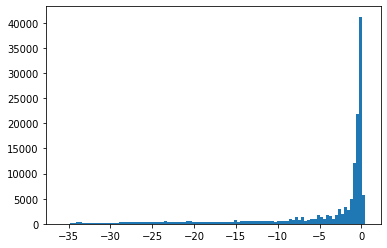

In [94]:
h2 = plt.hist(day1[0].y, bins=100)